# me 09.Z Homework
https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/09-serverless/homework.md

## Get model 
Model :
https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5

Downloaded manually

In [7]:
!dir dino_dragon_10_0.899.h5

 Volume in drive C has no label.
 Volume Serial Number is E8A5-BC16

 Directory of C:\Users\alain\Documents\prv\IT\mlzc-cnn

22/11/2022  12:28        89,759,168 dino_dragon_10_0.899.h5
               1 File(s)     89,759,168 bytes
               0 Dir(s)  87,346,823,168 bytes free


## Convert model to TF-Lite

In [33]:
import numpy as npy

In [8]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.11.0'

In [9]:
strFil = 'dino_dragon_10_0.899'
strFilInp = strFil + '.h5'
strFilOut = strFil + '_tflite.h5'
strFilInp , strFilOut

('dino_dragon_10_0.899.h5', 'dino_dragon_10_0.899_tflite.h5')

In [10]:
model = keras.models.load_model(strFilInp)

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\alain\AppData\Local\Temp\tmp09kcbzw5\assets


INFO:tensorflow:Assets written to: C:\Users\alain\AppData\Local\Temp\tmp09kcbzw5\assets


In [12]:
with tf.io.gfile.GFile(strFilOut, 'wb') as filOut:
    filOut.write(tflite_model)

In [13]:
!dir dino_dragon_10_0.899*.h5

 Volume in drive C has no label.
 Volume Serial Number is E8A5-BC16

 Directory of C:\Users\alain\Documents\prv\IT\mlzc-cnn

22/11/2022  12:28        89,759,168 dino_dragon_10_0.899.h5
22/11/2022  15:39        44,866,200 dino_dragon_10_0.899_tflite.h5
               2 File(s)    134,625,368 bytes
               0 Dir(s)  87,346,745,344 bytes free


## Q1 = +/- 44 MB

## Get input / ouput details of TFL

In [14]:
import tensorflow.lite as tflite 

In [15]:
# Unable to install it in this "pipenv" config :-(((
#import tflite_runtime.interpreter as tflite

In [16]:
interpreter = tflite.Interpreter(model_path=strFilOut)
interpreter.allocate_tensors()

In [18]:
input_details = interpreter.get_input_details()
input_index = input_details[0]['index']

output_details = interpreter.get_output_details()
output_index = output_details[0]['index']
input_index , output_index 

(0, 13)

## Q2= 13

## Image preparation

In [28]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    #img = img.resize(target_size, Image.NEAREST)
    img = img.resize(target_size, Image.Resampling.NEAREST )
    return img

In [29]:
urlImg = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg'

In [30]:
img = download_image(urlImg)

In [31]:
imgRes = prepare_image(img, (150,150))

C:\Users\alain\AppData\Local\Temp\ipykernel_4892\2487457277.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize(target_size, Image.NEAREST)


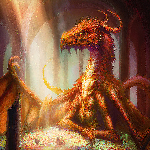

In [32]:
imgRes

In [ ]:
convert to numpy and divide by 255 

In [58]:
x = npy.array(imgRes , dtype='float32') / 255
x.shape

(150, 150, 3)

In [59]:
X = npy.array([x])
X.shape

(1, 150, 150, 3)

In [60]:
# first pixel of image - first channel R
x[0,0,0]

0.5529412

## Q3 = 0.552941

In [62]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)
preds

array([[0.82448506]], dtype=float32)

In [12]:
print( 'prediction =' , float(preds[0,0]) )

prediction = 0.8244850635528564


## Q4 = 0.8245

## lambda code (for debugging)

In [33]:
print(' > import ')
from io import BytesIO
from urllib import request
from PIL import Image
import numpy as npy
import tensorflow.lite as tflite 

print(' > functions ')
def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.Resampling.NEAREST )
    return img


print(' > variables ')
strFil = 'dino_dragon_10_0.899'
#strFilInp = strFil + '.h5'
strFilOut = strFil + '_tflite.h5'
urlImg = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg'


def predict(url):

    print('   > load interpreter ')
    interpreter = tflite.Interpreter(model_path=strFilOut)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    input_index = input_details[0]['index']
    output_details = interpreter.get_output_details()
    output_index = output_details[0]['index']


    print('   > load image ')
    img = download_image(url)
    imgRes = prepare_image(img, (150,150))
    x = npy.array(imgRes , dtype='float32') / 255
    X = npy.array([x])

    print('   > prediction ')
    interpreter.set_tensor(input_index, X)

    interpreter.invoke()
    preds = interpreter.get_tensor(output_index)

    pred = float(preds[0,0])
    print( '   * prediction =' , pred )
    jsoRes = { 'prediction' : pred}
    return(jsoRes)


def lambda_handler(event, context):
    url = event['url']
    res = predict(url)
    return res

if __name__ == "__main__":
    print(' > Test predict() ')
    res = predict(urlImg)
    print(' > res = ' , res )
    
    print(' > Test lambda_handler() ')
    res = lambda_handler(event={'url': urlImg} , context=() )
    print(' > res = ' , res)



 > import 
 > functions 
 > variables 
 > Test predict() 
   > load interpreter 
   > load image 
   > prediction 
   * prediction = 0.8244850635528564
 > res =  {'prediction': 0.8244850635528564}
 > Test lambda_handler() 
   > load interpreter 
   > load image 
   > prediction 
   * prediction = 0.8244850635528564
 > res =  {'prediction': 0.8244850635528564}


### Exported lambda code (previous cell) in "Homework09Predict.py"

In [1]:
!dir *.py

 Volume in drive C has no label.
 Volume Serial Number is E8A5-BC16

 Directory of C:\Users\alain\Documents\prv\IT\mlzc-cnn

23/11/2022  11:44             1,910 Homework09Predict.py
               1 File(s)          1,910 bytes
               0 Dir(s)  87,057,997,824 bytes free


In [2]:
# run code 
!python Homework09Predict.py

 > import 
 > functions 
 > variables 
 > Test predict() 
   > load interpreter 
   > load image 
   > prediction 
   * prediction = 0.8244850635528564
 > res =  {'prediction': 0.8244850635528564}
 > Test lambda_handler() 
   > load interpreter 
   > load image 
   > prediction 
   * prediction = 0.8244850635528564
 > res =  {'prediction': 0.8244850635528564}


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Test functions

In [7]:
import Homework09Predict

In [8]:
urlImg = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg'

In [9]:
Homework09Predict.predict(urlImg)

   > load interpreter 
   > load image 
   > prediction 
   * prediction = 0.8244850635528564


{'prediction': 0.8244850635528564}

In [10]:
Homework09Predict.lambda_handler(event={'url': urlImg} , context=() )

   > load interpreter 
   > load image 
   > prediction 
   * prediction = 0.8244850635528564


{'prediction': 0.8244850635528564}

## Load Docker image

In [11]:
!docker pull svizor42/zoomcamp-dino-dragon-lambda:v2

v2: Pulling from svizor42/zoomcamp-dino-dragon-lambda
Digest: sha256:46be01f7953cd48ebe526329ddf781d92019b9d44de4ecb67d11f56eaccf79cb
Status: Image is up to date for svizor42/zoomcamp-dino-dragon-lambda:v2
docker.io/svizor42/zoomcamp-dino-dragon-lambda:v2


In [16]:
!docker images svizor42/zoomcamp-dino-dragon-lambda

REPOSITORY                             TAG       IMAGE ID       CREATED      SIZE
svizor42/zoomcamp-dino-dragon-lambda   v2        20ef58b21a05   5 days ago   639MB


## Q5 = 639MB

## Build Docker

In [19]:
!dir Dockerfile

 Volume in drive C has no label.
 Volume Serial Number is E8A5-BC16

 Directory of C:\Users\alain\Documents\prv\IT\mlzc-cnn

23/11/2022  13:31               285 Dockerfile
               1 File(s)            285 bytes
               0 Dir(s)  86,585,327,616 bytes free


In [37]:
!type dockerfile

FROM svizor42/zoomcamp-dino-dragon-lambda:v2

RUN pip install keras-image-helper
RUN pip install https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.7.0-cp39-cp39-linux_x86_64.whl 

COPY Homework09Predict.py .

CMD [ "Homework09Predict.lambda_handler" ]


<div class="alert alert-block alert-warning">
<b>import tfile:</b> 
<p>before building image: change the import of tfile:
<ul>
<li>import tensorflow.lite as tflite
<li>import *tflite_runtime.interpreter* as tflite
</ul>
</div>

In [41]:
!docker build -t zoomcamp-dino-dragon-lambda .

#1 [internal] load build definition from Dockerfile
#1 sha256:ba5f4dc3c6a7bb96171db5d07684db08f588437b77fd34cd66036397042f23e1
#1 transferring dockerfile: 32B done
#1 DONE 0.0s

#2 [internal] load .dockerignore
#2 sha256:722cebb727dcb9cc3c294d60bd4d7fbd32b3867ff4887227091300bc9a0a277c
#2 transferring context: 2B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/svizor42/zoomcamp-dino-dragon-lambda:v2
#3 sha256:ce099ce3a9c4732d7780fbf70f02aad68c73f279182a55999a0214fc705011c8
#3 DONE 0.0s

#4 [1/4] FROM docker.io/svizor42/zoomcamp-dino-dragon-lambda:v2
#4 sha256:c3bb51f97f6b3af481275e256cce26f11f731bbb28f7c57019ae12c5c55d1141
#4 DONE 0.0s

#7 [internal] load build context
#7 sha256:0761f6a86dd149a3e9009f484e868154ac6fbe174024c90a99f0037f5150904c
#7 transferring context: 42B done
#7 DONE 0.0s

#6 [3/4] RUN pip install https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.7.0-cp39-cp39-linux_x86_64.whl
#6 sha256:4f004b5282fbc2298911bc2415c2af528d04

In [52]:
!docker images zoomcamp-dino-dragon-lambda*

REPOSITORY                    TAG       IMAGE ID       CREATED          SIZE
zoomcamp-dino-dragon-lambda   latest    87ead86d075f   40 seconds ago   820MB


## Run and test docker image
> docker run -it --rm -p 8080:8080 zoomcamp-dino-dragon-lambda

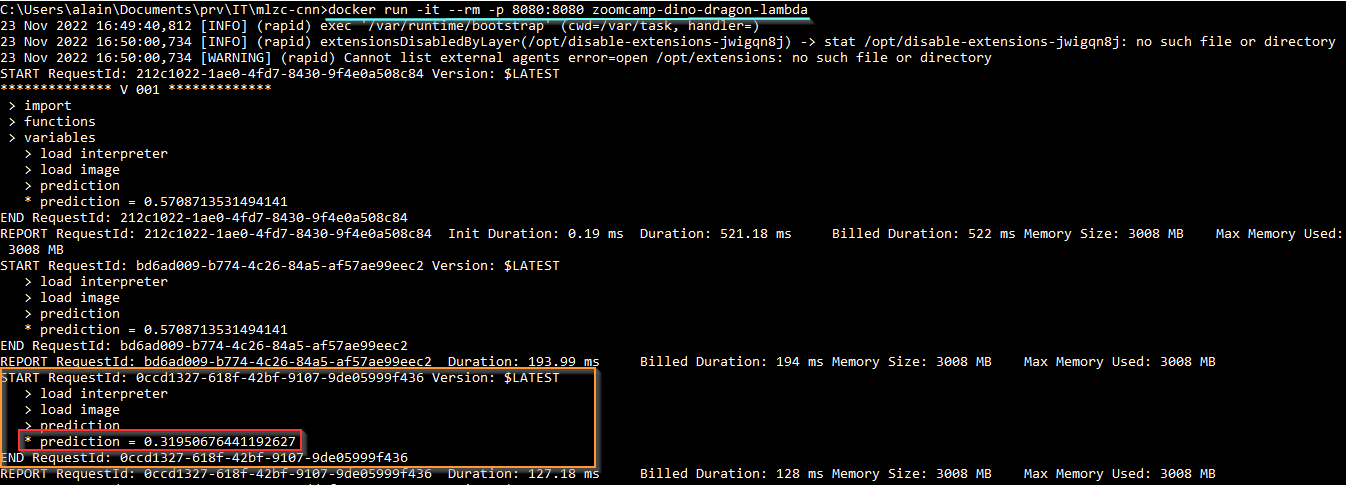

In [ ]:
import requests

In [59]:
urlImg = 'https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg'
data = { "url": urlImg }
data

{'url': 'https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg'}

In [61]:
url = "http://localhost:8080/2015-03-31/functions/function/invocations"

In [66]:
requests.post(url, json=data)

<Response [200]>

In [64]:
results = requests.post(url, json=data).json()
print(results)

{'prediction': 0.31950676441192627}


## Q6 = 0.32